In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import os
import math
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np


In [12]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, emb_dim, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.in_proj = nn.Linear(emb_dim, 3 * emb_dim, bias=in_proj_bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=out_proj_bias)
        self.d_heads = emb_dim // n_heads

    def forward(self, x, causal_mask=False):
        batch_size, seq_len, d_embed = x.shape
        interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)

        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, float('-inf'))

        weight /= math.sqrt(self.d_heads)
        weight = F.softmax(weight, dim=-1)
        out = weight @ v
        out = out.transpose(1, 2).reshape((batch_size, seq_len, d_embed))
        return self.out_proj(out)

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self, channels):
      super().__init__()
      self.groupnorm = nn.GroupNorm(32, channels)
      self.attention = SelfAttention(1, channels)

  def forward(self, x):
      # x: (batch_size, channels, h, w)
      residual = x.clone()

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x = self.groupnorm(x)

      n, c, h, w = x.shape

      # (batch_size, channels, h, w) -> (batch_size, channels, h * w)
      x = x.view((n, c, h * w))

      # (batch_size, channels, h * w) -> (batch_size, h * w, channels)
      x = x.transpose(-1, -2)

      # (batch_size, h * w, channels) -> (batch_size, h * w, channels)
      x = self.attention(x)

      # (batch_size, h * w, channels) -> (batch_size, channels, h * w)
      x = x.transpose(-1, -2)

      # (batch_size, channels, h * w) -> (batch_size, channels, h, w)
      x = x.view((n, c, h, w))

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x += residual

      return x


In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm1= nn.GroupNorm(32, in_channels)
        self. conv1= nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.groupnorm2= nn.GroupNorm(32, out_channels)
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu= nn.ReLU()
        
        if in_channels == out_channels:
            self.residual_layer= nn.Identity()
        else:
            self.residual_layer= nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        residual = x.clone()
        x = self.groupnorm1(x)
        x = F.selu(x)
        x = self.conv1(x)
        x = self.groupnorm2(x)
        x = self.conv2(x)
        
        return x + self.residual_layer(residual)

In [15]:
class Encoder(nn.Sequential):
    def  __init__(self):
        super().__init__(
            # (batch_size, channel, h, w) -> (batch_size, 128, h, w)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),

            # (batch_size, 128, h, w) -> (batch_size, 128, h, w)
            ResidualBlock(128, 128),

            # (batch_size, 128, h, w) -> (batch_size, 128, h / 2, w / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(128, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(256, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(256, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            AttentionBlock(512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.GroupNorm(32, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.SiLU(),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(512, 8, kernel_size=3, padding=1),

            # (batch_size, 8, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )
    def forward(self, x):
        # x: (batch_size, channel, h, w)

        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # (left, right, top, bottom)
            x = module(x)

        # (batch_size, 8, h / 8, w / 8) -> two tensors of shape (batch_size, 4, h / 8, w / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp log variance between -30 and 20
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization trick
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        x = mean + eps * std

        # Scale the latent representation
        x *= 0.18215

        return x

In [16]:
class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            nn.Conv2d(4, 512, kernel_size=3, padding=1),
            ResidualBlock(512, 512),
            AttentionBlock(512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            nn.Upsample(scale_factor=2),  # From 4x4 -> 8x8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            nn.Upsample(scale_factor=2),  # From 8x8 -> 16x16
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ResidualBlock(512, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            nn.Upsample(scale_factor=2),  # From 16x16 -> 32x32
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            ResidualBlock(256, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x /= 0.18215
        for module in self:
            x = module(x)
        return x

In [17]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
learning_rate = 1e-4
beta = 0.00025

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        reconstructed, encoded = model(images)
        recon_loss = nn.MSELoss()(reconstructed, images)
        mean, log_variance = torch.chunk(encoded, 2, dim=1)
        kl_div = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
        loss = recon_loss + beta * kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
              f'Loss: {loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_div.item():.4f}')

    train_losses.append(train_loss / len(train_loader))

print('Training finished!')


Epoch [1/50], Step [1/782], Loss: 1.0111, Recon Loss: 0.3795, KL Div: 2526.4260
Epoch [1/50], Step [2/782], Loss: 0.8474, Recon Loss: 0.4101, KL Div: 1749.2017
Epoch [1/50], Step [3/782], Loss: 0.7661, Recon Loss: 0.4051, KL Div: 1443.9697
Epoch [1/50], Step [4/782], Loss: 0.7012, Recon Loss: 0.4261, KL Div: 1100.4125
Epoch [1/50], Step [5/782], Loss: 0.6438, Recon Loss: 0.3897, KL Div: 1016.3295
Epoch [1/50], Step [6/782], Loss: 0.5030, Recon Loss: 0.2845, KL Div: 874.0461
Epoch [1/50], Step [7/782], Loss: 0.4540, Recon Loss: 0.2279, KL Div: 904.3779
Epoch [1/50], Step [8/782], Loss: 0.4734, Recon Loss: 0.2622, KL Div: 844.8275
Epoch [1/50], Step [9/782], Loss: 0.4472, Recon Loss: 0.2537, KL Div: 774.1648
Epoch [1/50], Step [10/782], Loss: 0.4430, Recon Loss: 0.2506, KL Div: 769.2472
Epoch [1/50], Step [11/782], Loss: 0.4355, Recon Loss: 0.2402, KL Div: 780.9694
Epoch [1/50], Step [12/782], Loss: 0.4333, Recon Loss: 0.2537, KL Div: 718.4806
Epoch [1/50], Step [13/782], Loss: 0.4114, R

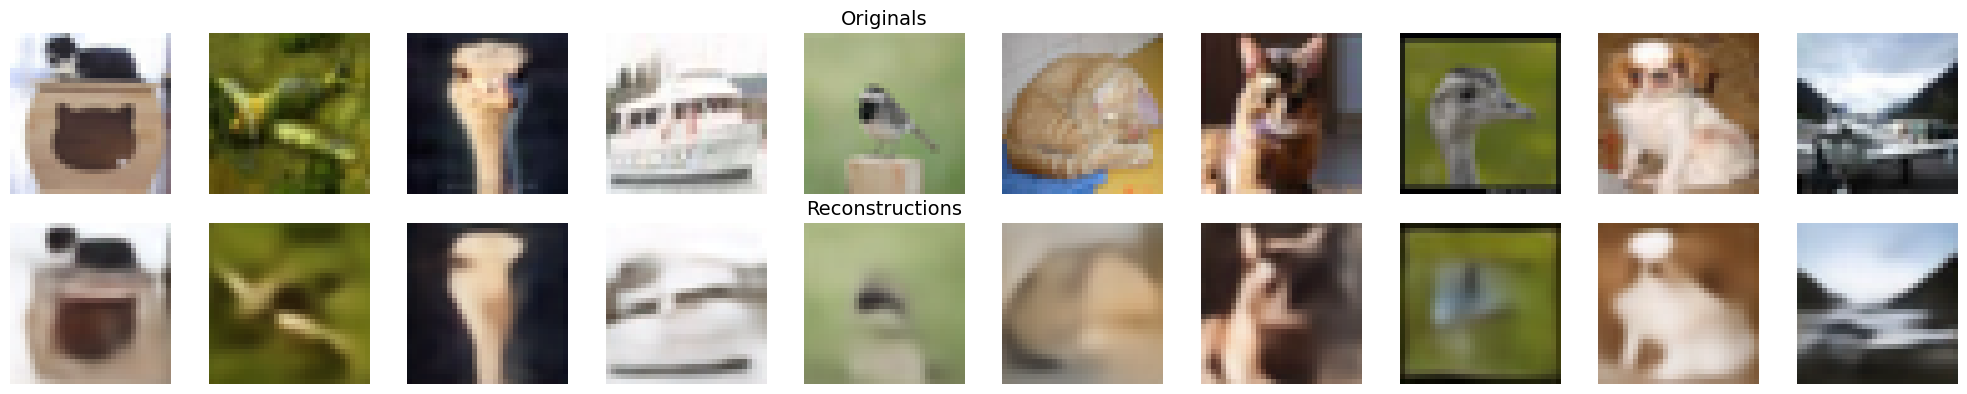

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

with torch.no_grad():
    images, _ = next(iter(train_loader))
    images = images.to(device)[:10]
    reconstructed, _ = model(images)
    
def denormalize(imgs):
    imgs = imgs.cpu().numpy()
    imgs = imgs * 0.5 + 0.5
    return np.clip(imgs, 0, 1)

images = denormalize(images)
reconstructed = denormalize(reconstructed)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[0, i].axis('off')
    if i == 4:
        axes[0, i].set_title('Originals', fontsize=14)

    axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
    axes[1, i].axis('off')
    if i == 4:
        axes[1, i].set_title('Reconstructions', fontsize=14)

plt.tight_layout()
plt.show()
